# Examples taken from the Elements of SMC paper

In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

/Users/gerardoduran/miniforge3/lib/python3.9/site-packages/jax/lib/__init__.py:31: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


In [2]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False
jnp.set_printoptions(suppress=True)

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from sequential_monte_carlo import NonMarkovianSM

$\newcommand{\normal}[3]{{ \mathcal{N}\left(#1 \vert #2, #3\right) }}$

We model a non-Markovian Gaussian sequence model as follows

$$
\begin{aligned}
    p(x_t \vert x_{t-1}) &= \normal{x_t}{\phi x_{t-1}}{q} \\
    p(y_t \vert x_{1:t}) &= \normal{y_t}{\sum_{k=1}^t \beta^{t-k}x_k}{r}
\end{aligned}
$$

To sample from $p(y_t \vert x_{1:t})$, note that

* at $t=1$, $\mathbb{E}[y_1] = x_1$
* at $t=2$, $\mathbb{E}[y_2] = \beta x_1 + x_2$
* at $t=3$, $\mathbb{E}[y_3] = \beta^2 x_1 + \beta x_2 + x_3$,

and so on.

We can rewrite this sequence recursively introducing a new variable $\mu_t$ defined as

$$
    \mu_t = \beta \mu_{t-1} + x_t,
$$

with $\mu_1 = x_1$. We obtain

* at $t=1$, $\mathbb{E}[y_1] = x_1 = \mu_1$
* at $t=2$, $\mathbb{E}[y_2] = \beta x_1 + x_2 = \beta \mu_1 + x_2 = \mu_2$
* at $t=3$, $\mathbb{E}[y_3] = \beta \mu_2 + x_3 = \mu_3$
* at $t=4$, $\mathbb{E}[y_4] = \beta \mu_3+ x_4$.

More generally,

* at $t=\tau$, $\mathbb{E}[y_\tau] = \beta\mu_{\tau - 1} + x_{\tau}$.


Hence, we rewrite the sequence model as follows

$$
\begin{aligned}
    p(x_t \vert x_{t-1}) &= \normal{x_t}{\phi x_{t-1}}{q} \\
    p(y_t \vert \mu_{t-1}, x_{t}) &= \normal{y_t}{\beta \mu_{t-1} + x_t}{r}
\end{aligned}
$$

## Example

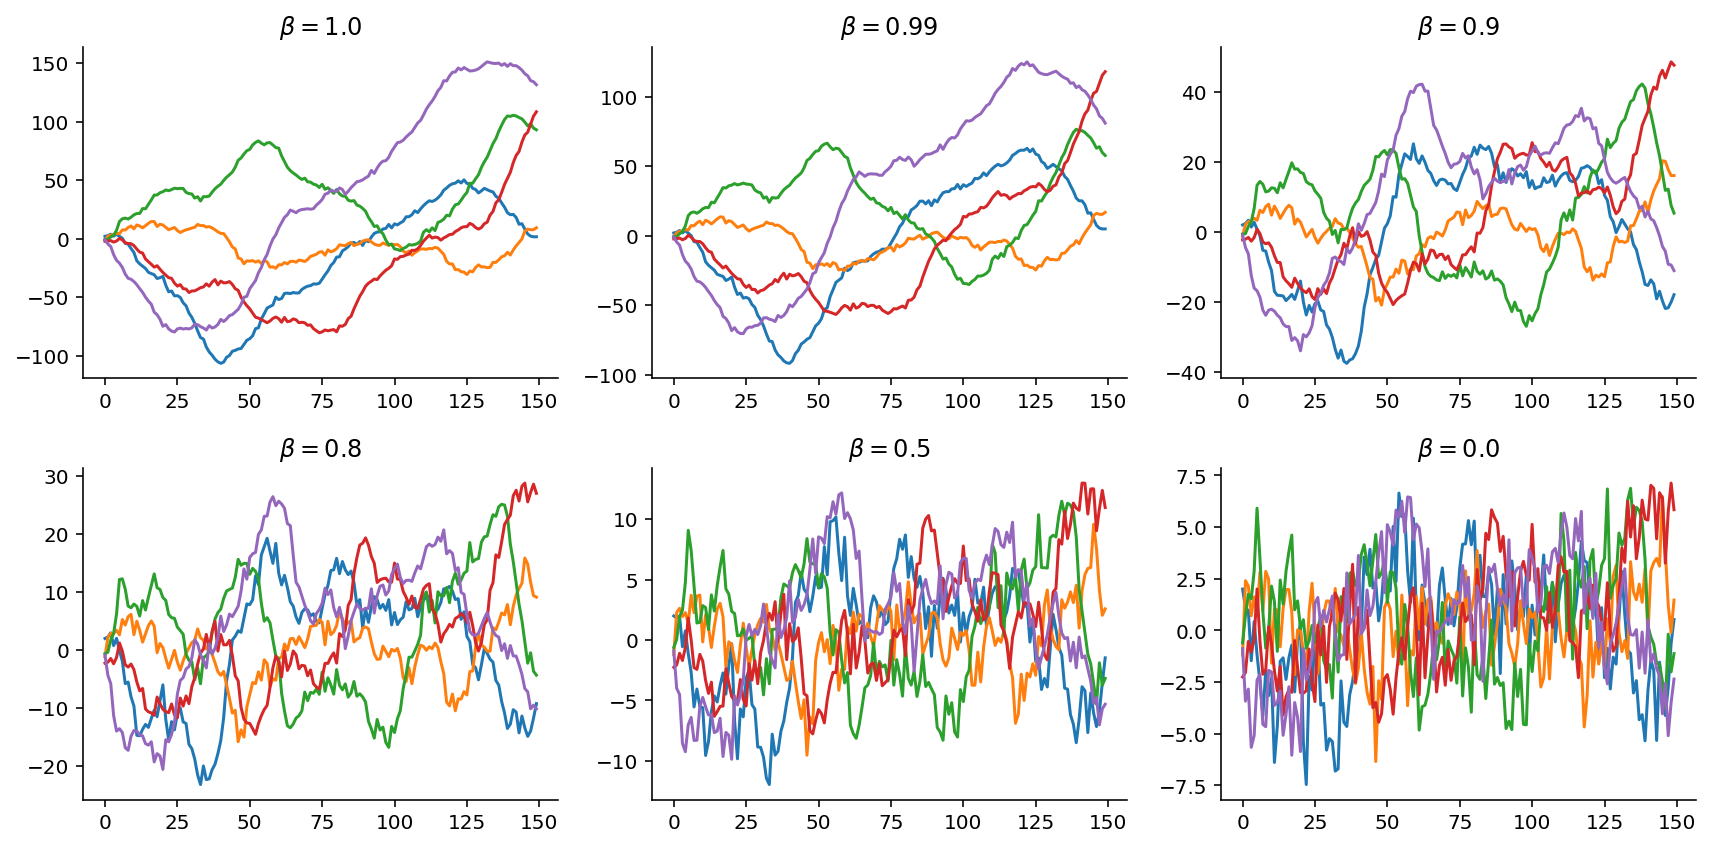

In [5]:
beta_values = jnp.array([1.0, 0.99, 0.9, 0.8, 0.5, 0])
phi, q, r = 0.9, 1.0, 1.0
T = 150

key = jax.random.PRNGKey(314)
fig, ax = plt.subplots(2, 3, figsize=(12, 6))
ax = ax.ravel()

for axi, beta in zip(ax, beta_values):
    seq_model = NonMarkovianSM(phi, beta, q, r)
    hist = seq_model.sample(key, T, 5)
    for simul_y in hist["y"]:
        axi.plot(simul_y)
        axi.set_title(rf"$\beta={beta:0.2}$")
plt.tight_layout()

## Sequential Importance Sampling (SIS)

* Variant of IS where the proposal distribution has an autoregressive structure. The weights are computed recursively.

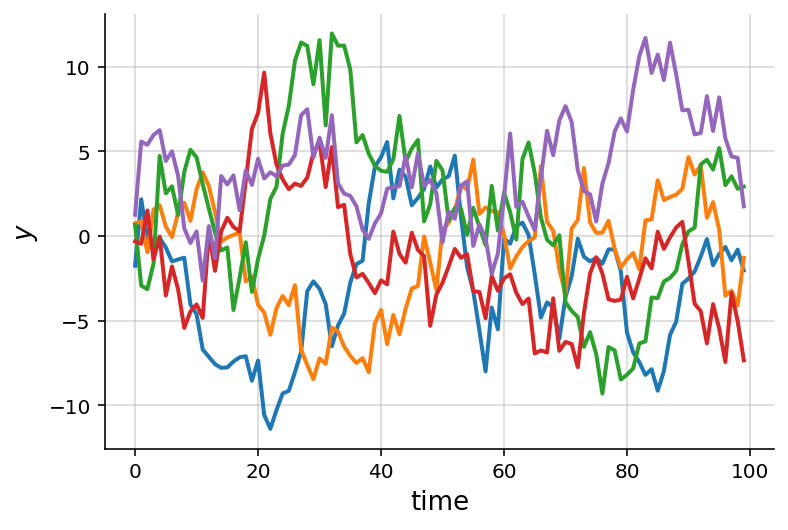

In [6]:
key = jax.random.PRNGKey(3141)


phi, q, beta, r = 0.9, 1.0, 0.5, 1.0
seq_model = NonMarkovianSM(phi, beta, q, r)
hist_target = seq_model.sample(key, 100, 5)
observations = hist_target["y"]

for sample in hist_target["y"]:
    plt.plot(sample, linewidth=2)
    
plt.xlabel("time", fontsize=13)
plt.ylabel("$y$", fontsize=13)
plt.grid(alpha=0.5)

In [7]:
key = jax.random.PRNGKey(314)
key_sample, key_filter = jax.random.split(key)
seq_model = NonMarkovianSM(phi, beta, q, r)
hist_target = seq_model.sample(key_sample, 100)
observations = hist_target["y"]
log_unnormalised_weights = seq_model.sequential_importance_sample(key_filter, observations, n_particles=5)
weights = jnp.exp(log_unnormalised_weights - jax.nn.logsumexp(log_unnormalised_weights, axis=1, keepdims=True))

weights[:10]

DeviceArray([[0.12337945, 0.00256026, 0.44109172, 0.06145081, 0.37151778],
             [0.02348423, 0.00000016, 0.6114105 , 0.10790044, 0.25720483],
             [0.00000012, 0.        , 0.8230217 , 0.14540641, 0.03157165],
             [0.        , 0.        , 0.7760949 , 0.22178279, 0.00212223],
             [0.        , 0.        , 0.988311  , 0.01168872, 0.        ],
             [0.        , 0.        , 1.        , 0.0000002 , 0.        ],
             [0.        , 0.        , 1.        , 0.00000025, 0.        ],
             [0.        , 0.        , 1.        , 0.        , 0.        ],
             [0.        , 0.        , 1.        , 0.        , 0.        ],
             [0.        , 0.        , 1.        , 0.        , 0.        ]],            dtype=float32)

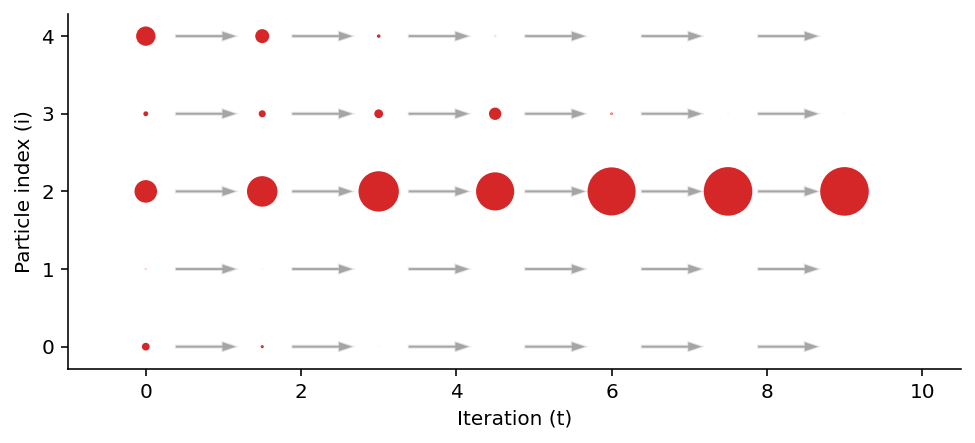

In [8]:
norm_cst = weights[0].sum()


n_steps = 7
spacing = 1.5
radii = 1 * weights[0] / norm_cst

fig, ax = plt.subplots(figsize=(8, 6))
ax.set_aspect(1)
for col, weights_row in enumerate(weights[:n_steps]):
    norm_cst = weights_row.sum()
    radii = weights_row / norm_cst * 0.3
    for row, rad in enumerate(radii):
        if col != n_steps - 1:
            plt.arrow(spacing * (col + 0.25), row, 0.6, 0, width=0.05, edgecolor="white", facecolor="tab:gray", alpha=0.7)
        circle = plt.Circle((spacing * col, row), rad, color="tab:red")
        ax.add_artist(circle)



plt.xlim(-1, n_steps * spacing)
plt.xlabel("Iteration (t)")
plt.ylabel("Particle index (i)")
plt.xticks();

# Sequential Monte Carlo (SMC)
## SCM ≡ SIR ≡ SISR

In [58]:
key = jax.random.PRNGKey(314)
hist = seq_model.sequential_monte_carlo(key, observations, n_particles=5)
hist["weights"][:10]

DeviceArray([[0.05555233, 0.00107321, 0.0053261 , 0.93800914, 0.00003929],
             [0.40667263, 0.0079113 , 0.45697495, 0.04834344, 0.08009775],
             [0.05017593, 0.00000355, 0.00382371, 0.05645955, 0.8895373 ],
             [0.21861662, 0.03254522, 0.28307933, 0.19562058, 0.27013826],
             [0.00282553, 0.0000421 , 0.11914458, 0.2352027 , 0.64278555],
             [0.29941893, 0.00000335, 0.58107454, 0.11936738, 0.00013555],
             [0.00877714, 0.41301942, 0.20371662, 0.17692608, 0.19756071],
             [0.00005832, 0.21194817, 0.00000002, 0.7879878 , 0.00000547],
             [0.29790613, 0.01478354, 0.2987359 , 0.17092192, 0.21765241],
             [0.4321144 , 0.01710412, 0.00471473, 0.0842867 , 0.46178007]],            dtype=float32)

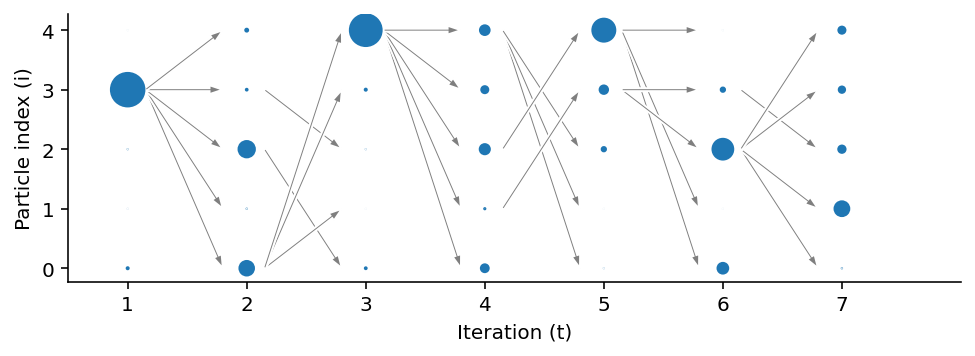

In [263]:
n_steps = 6 + 2
spacing = 2
weights_subset = hist["weights"][:n_steps]
# sampled indices represent the "position" of weights at the next time step
ix_subset = hist["indices"][:n_steps][1:]

fig, ax = plt.subplots(figsize=(8, 6))
ax.set_aspect(1)

for it, (weights_row, p_target) in enumerate(zip(weights_subset, ix_subset)):
    norm_cst = weights_row.sum()
    radii = weights_row / norm_cst * 0.3
    
    for particle_ix, (rad, target_ix) in enumerate(zip(radii, p_target)):
        if it != n_steps - 2:
            diff = particle_ix - target_ix
            plt.arrow(spacing * (it + 0.15), target_ix, 1.3, diff, width=0.05,
                      edgecolor="white", facecolor="tab:gray", alpha=1.0, length_includes_head=True)
        circle = plt.Circle((spacing * it, particle_ix), rad, color="tab:blue")
        ax.add_artist(circle)


plt.xlim(-1, n_steps * spacing - 2)
plt.xlabel("Iteration (t)")
plt.ylabel("Particle index (i)")

xticks_pos = jnp.arange(0, n_steps * spacing - 2, 2)
xticks_lab = jnp.arange(1, n_steps)
ylims = ax.axes.get_ylim()

plt.xticks(xticks_pos, xticks_lab);
# plt.grid(alpha=0.7, c="tab:purple")

## Path degeracy

Steps
```
3 -> 0
0 -> 4
4 -> 1
1 -> 3
3 -> 2
2 -> 4
```

In [217]:
ix_path = ix_subset[:n_steps - 2]

ix_map = jnp.repeat(jnp.arange(5)[None, :], 6, axis=0)

ix_path = jnp.stack([ix_path, ix_map], axis=0)

In [171]:
ix_path[:, -1, :] # 2 -> 4

DeviceArray([[2, 2, 3, 2, 2],
             [0, 1, 2, 3, 4]], dtype=int32)

In [175]:
ix_path[:, -2, :] # 3 -> 2

DeviceArray([[4, 4, 3, 3, 4],
             [0, 1, 2, 3, 4]], dtype=int32)

In [179]:
ix_path[:, -3, :] # 1 -> 3

DeviceArray([[4, 4, 4, 1, 2],
             [0, 1, 2, 3, 4]], dtype=int32)

In [180]:
ix_path[:, -4, :] # 4 -> 1

DeviceArray([[4, 4, 4, 4, 4],
             [0, 1, 2, 3, 4]], dtype=int32)

In [188]:
ix_path[:, -5, :] # 0 -> 4

DeviceArray([[2, 0, 3, 0, 0],
             [0, 1, 2, 3, 4]], dtype=int32)

In [190]:
ix_path[:, -6, :] # 3 -> 0

DeviceArray([[3, 3, 3, 3, 3],
             [0, 1, 2, 3, 4]], dtype=int32)

In [194]:
ix_path = ix_subset[:n_steps - 2]
ix_path

DeviceArray([[3, 3, 3, 3, 3],
             [2, 0, 3, 0, 0],
             [4, 4, 4, 4, 4],
             [4, 4, 4, 1, 2],
             [4, 4, 3, 3, 4],
             [2, 2, 3, 2, 2]], dtype=int32)

In [238]:
def find_path(ix_path, final_state):
    curr_state = final_state
    path = [curr_state]
    for i in range(1, 7):
        curr_state, _ = ix_path[:, -i, curr_state]
        path.append(curr_state)
    path = path[::-1]
    return path

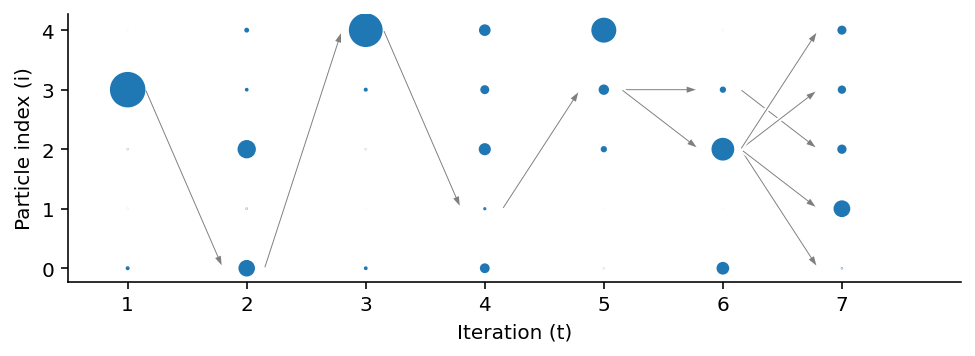

In [264]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_aspect(1)

for final_state in range(5):
    path = find_path(ix_path, final_state)
    path_beg, path_end = path[:-1], path[1:]
    for it, (beg, end) in enumerate(zip(path_beg, path_end)):
        diff = end - beg
        plt.arrow(spacing * (it + 0.15), beg, 1.3, diff, width=0.05,
                  edgecolor="white", facecolor="tab:gray", alpha=1.0, length_includes_head=True)

for it, weights_row in enumerate(weights_subset[:-1]):
    norm_cst = weights_row.sum()
    radii = weights_row / norm_cst * 0.3
    
    for particle_ix, rad in enumerate(radii):
        circle = plt.Circle((spacing * it, particle_ix), rad, color="tab:blue")
        ax.add_artist(circle)
        
plt.xlim(-1, n_steps * spacing - 2)
plt.ylim(*ylims)
plt.xlabel("Iteration (t)")
plt.ylabel("Particle index (i)")

xticks_pos = jnp.arange(0, n_steps * spacing - 2, 2)
xticks_lab = jnp.arange(1, n_steps)

plt.xticks(xticks_pos, xticks_lab);